In [5]:
import numpy as np
import matplotlib.pyplot as pl
import seaborn.apionly as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter("ignore")

import theano
import theano.tensor as T

## Feature engineering vs <br/>Representation learning

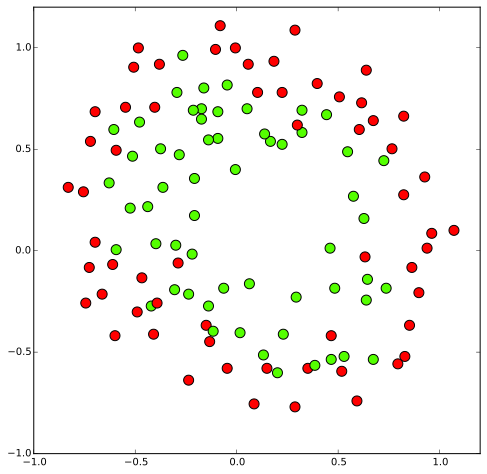

In [6]:
data = np.matrix(np.loadtxt("../lec01/ex2data2.txt",delimiter=","))
np.random.shuffle(data)

pl.figure(figsize=(8,8))
pl.scatter(data[:,0].tolist(), data[:,1].tolist(),
               c=data[:,2].tolist(),
               s=100, cmap=pl.cm.get_cmap('prism'));
pl.ylim(-1,1.2);
pl.xlim(-1,1.2);
pl.legend();

In [13]:
n = 1
sgd = True

In [14]:
def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

X = powerme(data[:,0], data[:,1], n)
Y = data[:,2]

print(X[:5,:])

[[ 1.       -0.7405    0.59274 ]
 [ 1.        0.26827   0.57546 ]
 [ 1.        0.44371   0.72523 ]
 [ 1.        0.21711  -0.43836 ]
 [ 1.        0.085526  0.96141 ]]


##Logistic regression in Theano

In [15]:
def logistic(x):
    return 1.0 / (1.0 + T.exp(-x))

def graph_logreg(X):
    idim = X.shape[1]
    odim = 1
    
    x = T.dmatrix("x")
    y = T.dmatrix("y")
    theta = theano.shared(np.random.randn(idim, odim), name='w')

    # the model
    prob = logistic(T.dot(x, theta))
    # the decision function
    pred = prob > 0.5                    
    # the cost function
    xent = -y * T.log(prob) - (1 - y) * T.log(1 - prob) 
    cost = xent.mean()

    # the gradients
    gtheta = T.grad(cost, theta)

    # the learning rate
    alpha = T.scalar("alpha")
    # the SGD update rule
    update = theano.function(
          inputs=[x, y, alpha],
          outputs=[cost, theta],
          updates=[[theta, theta - alpha * gtheta]])
    # application of the model to input
    predict = theano.function(inputs=[x], outputs=pred)
    
    return update, predict

## A simplistic SGD algorithm in Theano with mini-batches

In [18]:
def mbSGD(update_rule, X, y, 
         alpha=0.01, maxSteps=10000, batchSize = 10):
    i = 0
    b = batchSize
    m = X.shape[0]
    for i in range(maxSteps):
        start = (i*b) % m
        end   = ((i+1)*b) % m
        if(end <= start):
            end = m
        
        XBatch = X[start:end]
        YBatch = y[start:end]
        
        out = update_rule(XBatch, YBatch, alpha)
    return out

0.682652684495558
[-0.0872813]
[ 0.01425646]
[-0.15191684]


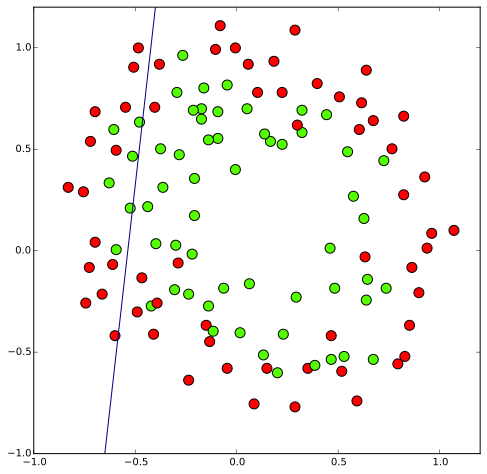

In [17]:
pl.figure(figsize=(8,8))
pl.scatter(X[:,2].tolist(),
               X[:,1].tolist(),
               c=Y.tolist(),
               s=100, cmap=pl.cm.get_cmap('prism'));


if sgd:
    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.001),
                         np.arange(-1.5, 1.5, 0.001))
    
    update, predict = graph_logreg(X)
    
    cost, thetaBest = mbSGD(update, X, Y,
                  alpha=0.1, maxSteps=50000, batchSize = 20)
    print(cost)
    for p in thetaBest:
        print(p)
    
    l = len(xx.ravel())
    C = powerme(xx.reshape(l,1),yy.reshape(l,1),n)
    z = predict(C).reshape(np.sqrt(l),np.sqrt(l))

    cont = pl.contour(xx, yy, z, levels=[0.5], lw=5);
    
pl.ylim(-1,1.2);
pl.xlim(-1,1.2);
pl.legend();

## A simple 2-layer neural network in Theano

In [20]:
def graph_mlp(X):
    idim = X.shape[1]
    hdim = 3
    odim = 1
    
    x = T.dmatrix("x")
    y = T.dmatrix("y")
    theta1 = theano.shared(np.random.randn(idim, hdim), name='w1')
    theta2 = theano.shared(np.random.randn(hdim, odim), name='w2')

    # the model
    lay1 = logistic(T.dot(x, theta1))
    prob = logistic(T.dot(lay1, theta2))
    # the decision function
    pred = prob > 0.5                    
    # the cost function
    xent = -y * T.log(prob) - (1 - y) * T.log(1 - prob) 
    cost = xent.mean()

    # the gradients
    gtheta1, gtheta2 = T.grad(cost, [theta1, theta2])

    # the learning rate
    alpha = T.scalar("alpha")
    # the SGD update rule
    update = theano.function(
          inputs=[x, y, alpha],
          outputs=[cost, theta1, theta2],
          updates=[[theta1, theta1 - alpha * gtheta1],
                  [theta2, theta2 - alpha * gtheta2]])
    # application of the model to input
    predict = theano.function(inputs=[x], outputs=pred)
    
    return update, predict

0.4778454934698818
[[ 2.30329411 -1.31169223 -2.62596863]
 [ 2.67525931 -3.7190316   4.01379424]
 [ 8.84957023  2.17110815  1.92875721]]
[[ 12.87544516]
 [-14.42368412]
 [-18.44070461]]


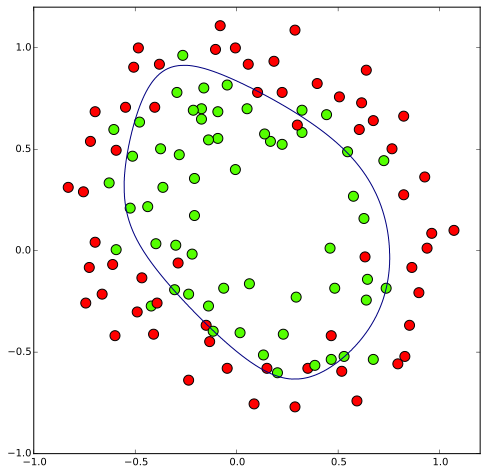

In [21]:
pl.figure(figsize=(8,8))
pl.scatter(X[:,2].tolist(),
               X[:,1].tolist(),
               c=Y.tolist(),
               s=100, cmap=pl.cm.get_cmap('prism'));

XNeural = X[:,:3]

if sgd:
    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.001),
                         np.arange(-1.5, 1.5, 0.001))
    
    update, predict = graph_mlp(XNeural)
    
    cost, *thetaBest = mbSGD(update, XNeural, Y,
                  alpha=0.1, maxSteps=50000, batchSize = 20)
    print(cost)
    for p in thetaBest:
        print(p)
    
    l = len(xx.ravel())
    C = powerme(xx.reshape(l,1),yy.reshape(l,1),1)
    z = predict(C).reshape(np.sqrt(l),np.sqrt(l))

    cont = pl.contour(xx, yy, z, levels=[0.5], lw=5);
    
pl.ylim(-1,1.2);
pl.xlim(-1,1.2);
pl.legend();